In [1]:
import librosa
from aubio import source, onset
import numpy as np
import math
import os
from os.path import join
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [103]:
wav_lst = os.listdir(join('ZD20K', 'outputs'))
sr = 24000

## Librosa

In [148]:
def librosa_onsets(file_path, fs=24000, mode='env'):
    signal, fs = librosa.load(file_path, sr=fs)
    
    if mode == 'time':
        ### wait: gap between peaks; pre/post_max/avg: windowing; delta: threshold ###
        try:
            onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True, 
                                                  wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1, delta=0.2)
        except:
            return np.array([])
        #onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True)
    elif mode == 'env':
        o_env = librosa.onset.onset_strength(signal, sr=fs)
        times = librosa.times_like(o_env, sr=fs)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=fs, backtrack=True)
        onset_ts = librosa.frames_to_time(onset_frames)
        
        D = np.abs(librosa.stft(signal))
        fig, ax = plt.subplots(1, 1)
        ax.set_title('Librosa Onset Detection')
        ax.plot(times, o_env, label='Onset strength')
        ax.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
        ax.legend()
        ax.set_xlabel('Time (s)')
    else:
        raise ValueError("Do not support this mode!")
        
    return onset_ts

In [119]:
signal ,fs = librosa.load(join('ZD20K', 'outputs', wav_lst[0]), sr=sr)

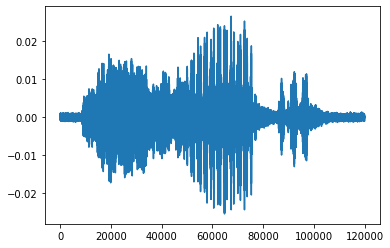

In [120]:
plt.plot(signal)
plt.show()

array([  2,   4,  12,  18,  26,  32,  34,  41,  44,  51,  54,  59,  61,
        71,  77,  82,  84,  95, 104, 110, 115, 121, 123, 128, 130, 133,
       138, 141, 144, 146, 149, 154, 156, 159, 161, 164, 186, 199, 215,
       221, 241, 251, 271, 281, 288, 296, 306, 312, 318, 321, 324])

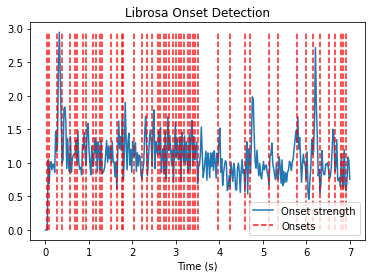

In [43]:
librosa_onsets(join('outputs', wav_lst[0]))  # After backtrack=True

In [46]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time'

array([0.04266667, 0.08533333, 0.256     , 0.384     , 0.55466667,
       0.68266667, 0.72533333, 0.87466667, 0.93866667, 1.088     ,
       1.152     , 1.25866667, 1.30133333, 1.51466667, 1.64266667,
       1.74933333, 1.792     , 2.02666667, 2.21866667, 2.34666667,
       2.45333333, 2.58133333, 2.624     , 2.73066667, 2.77333333,
       2.83733333, 2.944     , 3.008     , 3.072     , 3.11466667,
       3.17866667, 3.28533333, 3.328     , 3.392     , 3.43466667,
       3.49866667, 3.968     , 4.24533333, 4.58666667, 4.71466667,
       5.14133333, 5.35466667, 5.78133333, 5.99466667, 6.144     ,
       6.31466667, 6.528     , 6.656     , 6.784     , 6.848     ,
       6.912     ])

In [61]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time' with peak_pick args

array([0.04266667, 0.21333333, 0.256     , 0.384     , 1.792     ,
       2.73066667, 2.77333333, 3.11466667, 4.65066667, 4.71466667,
       6.144     ])

In [132]:
librosa_onsets(join('ZD20K', 'outputs', wav_lst[0]), mode='time') # Default setting!? After delta=0.2

array([0.32 , 0.576])

In [133]:
lib_count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = librosa_onsets(join('ZD20K', 'outputs', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    if len(lib_count_lst) > 9:
        break
    
print(lib_count_lst)

[(2, [0.32, 0.576]), (1, [2.24]), (1, [0.8533333333333334]), (4, [0.256, 0.49066666666666664, 2.026666666666667, 2.8586666666666667]), (3, [0.042666666666666665, 2.0906666666666665, 2.517333333333333]), (1, [0.042666666666666665]), (1, [1.6853333333333333]), (4, [0.042666666666666665, 0.768, 0.8746666666666667, 0.9813333333333333]), (1, [0.6826666666666666]), (2, [0.042666666666666665, 3.925333333333333])]


In [63]:
assert len(lib_count_lst)==len(gt_lst)
lib_error_count = []
lib_error_onset_t = []
for idx, tup in enumerate(lib_count_lst):
    lib_error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(lib_error_count) / len(lib_error_count))

12.2


## Aubio

In [135]:
def get_onset_times(file_path, win_div=4):
    window_size = 1024 # FFT size
    hop_size = window_size // win_div

    sample_rate = 0
    src_func = source(file_path, sample_rate, hop_size)
    sample_rate = src_func.samplerate
    onset_func = onset('default', window_size, hop_size)
    
    duration = float(src_func.duration) / src_func.samplerate

    onset_times = [] # seconds
    while True: # read frames
        samples, num_frames_read = src_func()
        if onset_func(samples):
            onset_time = onset_func.get_last_s()
            if onset_time < duration:
                onset_times.append(onset_time)
            else:
                break
        if num_frames_read < hop_size:
            break
    
    return onset_times

In [136]:
file_path = join('ZD20K', 'outputs', wav_lst[0])
onset_times = get_onset_times(file_path)

In [143]:
count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = get_onset_times(join('ZD20K', 'outputs', file), win_div=2)
    count_lst.append((len(onset_time), onset_time))
    if len(count_lst) > 9:
        break
    
print(count_lst)

[(7, [0.0, 0.2043083906173706, 0.3319047689437866, 1.1173468828201294, 1.9653061628341675, 2.059659957885742, 2.164625883102417]), (2, [1.2290703058242798, 1.7537188529968262]), (9, [0.48217687010765076, 0.6090475916862488, 1.3082993030548096, 1.517346978187561, 1.5733786821365356, 1.6295918226242065, 1.6893877983093262, 1.7456235885620117, 1.8044670820236206]), (10, [0.1531972736120224, 0.2757823169231415, 0.3731292486190796, 0.4663265347480774, 0.575986385345459, 0.7185714244842529, 0.7724036574363708, 0.8351020216941833, 1.6122221946716309, 1.7330158948898315]), (2, [0.0, 0.7468934059143066]), (1, [0.0]), (3, [0.9247392416000366, 1.2026077508926392, 1.2604762315750122]), (7, [0.15768706798553467, 0.2146485298871994, 0.26573696732521057, 0.3880952298641205, 1.1408843994140625, 1.2304534912109375, 1.338344693183899]), (6, [0.0, 0.41814059019088745, 0.9612471461296082, 1.346258521080017, 1.4593197107315063, 1.5599772930145264]), (1, [0.0])]


In [3]:
with open('annotations.json') as f:
    anns = json.load(f)

### Ground-truth

In [21]:
gt_lst = []

for file in os.listdir('outputs'):
    key_name = file.split('.')[0]
    
    start_ts = [item['start_t'] for item in anns[key_name]['birds']]
    
    gt_lst.append((anns[key_name]['count'], sorted(start_ts)))
    
print(gt_lst)

[(10, [0.015876305004615496, 0.04055874747533283, 0.8560014930756557, 1.113190095751739, 1.4673785172424894, 1.8090983152621483, 1.9343189066546818, 2.1345905017997007, 4.339293069060367, 5.427446743592197]), (10, [0.37726755844016974, 0.39026541015092964, 0.865730286394628, 1.289283348606935, 1.3144453738689539, 2.045300700875337, 4.526546265432463, 4.606212095954632, 4.9642929183415685, 5.358079898350199]), (10, [2.0422582831429015, 2.4019279826428646, 3.684572612475001, 4.631383724230315, 5.174263512148089, 5.808403381671271, 7.213222444554427, 7.247640891734407, 8.61479029189398, 9.305477105584105]), (10, [0.08957469750368154, 0.7055040435527499, 0.7437540168754013, 1.1322561652724625, 1.1368965504921866, 2.508784130854608, 2.9445331997541864, 3.1993645288836, 3.36240098300053, 4.24348693561246]), (10, [0.7902820896082009, 0.8351156931336404, 0.9657154572200708, 2.8727539475059127, 4.742736772641742, 4.8263467105994025, 6.537025166068086, 7.504311641580494, 7.643364108606821, 7.805

In [22]:
assert len(count_lst)==len(gt_lst)
error_count = []
error_onset_t = []
for idx, tup in enumerate(count_lst):
    error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(error_count) / len(error_count))

3.6


# Evaluation

In [ ]:
# Load annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

with open(join('annotations_pred_6_10.json')) as f:
    anns6_10 = json.load(f)
    
anns.update(anns6_10)
print(len(anns))

## Librosa & Aubio eval

In [101]:
lib_count_lst, aub_count_lst = [], []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = librosa_onsets(join('ZD20K', 'outputs', file), mode='time')
    onset_times_aub = get_onset_times(join('ZD20K', 'outputs', file), win_div=2)
    
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    aub_count_lst.append((len(onset_times_aub), onset_times_aub))
    break
    
print(lib_count_lst, aub_count_lst)

[(12, [0.042666666666666665, 0.32, 0.576, 1.8986666666666667, 2.048, 2.2186666666666666, 2.3253333333333335, 2.432, 2.538666666666667, 2.6453333333333333, 3.0933333333333333, 3.541333333333333])] [(19, [0.0, 0.20789115130901337, 0.33396825194358826, 1.1109297275543213, 1.1709524393081665, 1.2301360368728638, 1.2886848449707031, 1.3488208055496216, 1.4080045223236084, 1.4671655893325806, 1.5267120599746704, 1.5873695611953735, 1.646417260169983, 1.7078458070755005, 1.9541043043136597, 2.0360543727874756, 2.093038558959961, 2.145986318588257, 2.1974830627441406])]


In [149]:
num_of_onset_samples = 0
for index, (filename, item) in enumerate(anns.items()):
    if item['count_num_pred'] is not None:
        if os.path.isfile(join('ZD20K', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K', 'outputs', filename + '.wav')
        elif os.path.isfile(join('ZD20K_count6-10', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K_count6-10', 'outputs', filename + '.wav')
        else:
            raise ValueError(filename + '.wav', " does not exist!")
            
        onset_time = librosa_onsets(path_to_file, mode='time')
        librosa_count = len(onset_time)
        anns[filename]['count_num_lib'] = librosa_count
        
        onset_times_aub = get_onset_times(path_to_file, win_div=2)
        aub_count = len(onset_times_aub)
        anns[filename]['count_num_aub'] = aub_count
        
        num_of_onset_samples += 1
        
print("Detected total samples = ", num_of_onset_samples)

Detected total samples =  9998


In [151]:
# Save updated anns with gt-lib & aub
with open('annotations_count1-10_lib_aub.json', 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)

## Count Correlation to P.L. P.R. P.A. P.D.

In [3]:
sort_attr = 'PolyphonyLevel'
PR_lst = sorted(anns.items(), key=lambda x: x[1][sort_attr], reverse=True)

In [4]:
len(PR_lst)

40000

In [5]:
count_lst, pl_lst, pa_lst, pr_lst, pd_lst = [], [], [], [], []

for item in PR_lst:
    pl_lst.append(item[1]['PolyphonyLevel'])
    pa_lst.append(item[1]['PolyphonicArea'])
    pr_lst.append(item[1]['PolyphonicRatio'])
    pd_lst.append(item[1]['PolyphonicDensity'])
    count_lst.append(item[1]['count'])

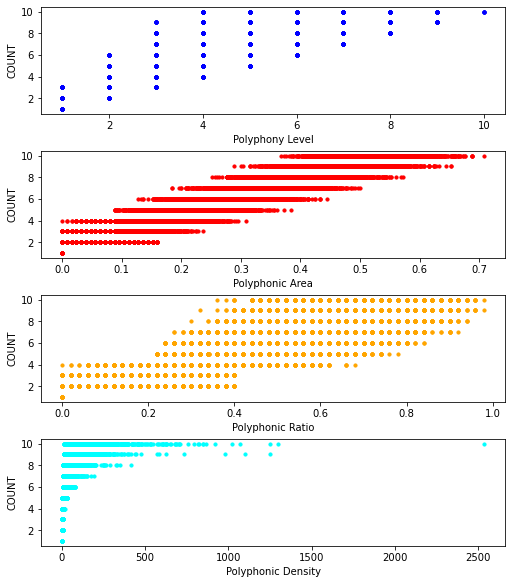

In [6]:
fig, ax = plt.subplots(4, 1, figsize=(7, 8), constrained_layout=True)

ax[0].scatter(pl_lst, count_lst, color='b', s=10)
ax[0].set_xlabel("Polyphony Level")
ax[0].set_ylabel("COUNT")

ax[1].scatter(pa_lst, count_lst, color='r', s=10)
ax[1].set_xlabel("Polyphonic Area")
ax[1].set_ylabel("COUNT")

ax[2].scatter(pr_lst, count_lst, color='orange', s=10)
ax[2].set_xlabel("Polyphonic Ratio")
ax[2].set_ylabel("COUNT")

ax[3].scatter(pd_lst, count_lst, color='cyan', s=10)
ax[3].set_xlabel("Polyphonic Density")
ax[3].set_ylabel("COUNT")

#fig.savefig('ZD20K_distribution', facecolor='white', transparent=False)
plt.show()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


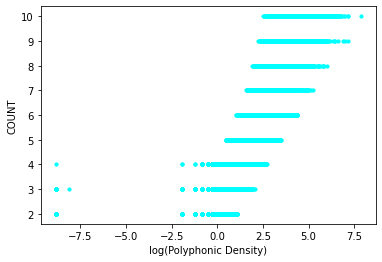

In [7]:
fig2, ax2 = plt.subplots()

ax2.scatter(np.log(pd_lst), count_lst, color='cyan', s=10)
ax2.set_xlabel("log(Polyphonic Density)")
ax2.set_ylabel("COUNT")

#fig2.savefig('ZD20K_log-polyphonicDensity', facecolor='white', transparent=False)
plt.show()

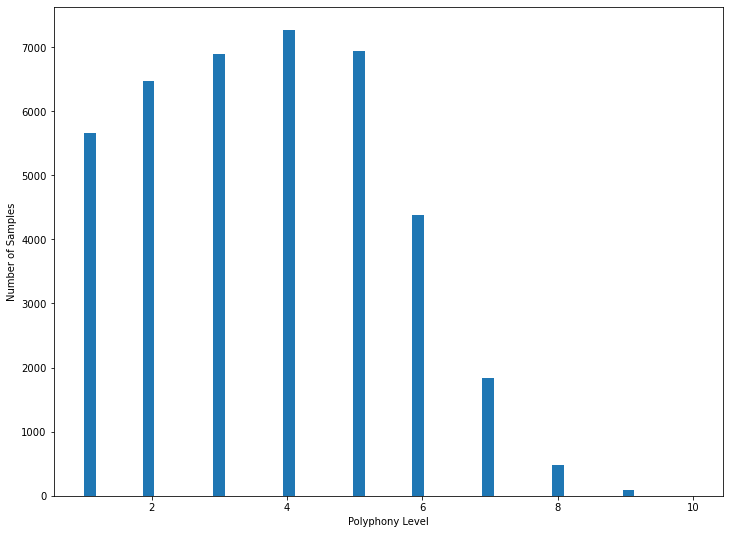

In [11]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(pl_lst, bins='auto', rwidth=0.99)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

## Polyphony Level

In [138]:
# Load annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

with open(join('annotations_pred_6_10.json')) as f:
    anns6_10 = json.load(f)

anns.update(anns6_10)
print(len(anns))

40000


In [152]:
def eval_polyphony(ann, sort_attr = 'PolyphonyLevel'):
    
    PR_lst = sorted(ann.items(), key=lambda x: x[1][sort_attr], reverse=False)
    
    attr_lst = []
    count_num_pred_lst, count_lst = [], []
    snr_lst = []
    lib_lst, aub_lst = [], []

    for item in PR_lst:
        if item[1]['count_num_pred'] is not None:
            attr_lst.append(item[1][sort_attr])
            count_lst.append(item[1]['count'])
            count_num_pred_lst.append(item[1]['count_num_pred'])
            snr_lst.append(item[1]['snr'])
            
            lib_lst.append(item[1]['count_num_lib'])
            aub_lst.append(item[1]['count_num_aub'])
            
            
    print("Number of test samples = ", len(attr_lst))
    
    return attr_lst, count_num_pred_lst, count_lst, snr_lst, lib_lst, aub_lst

In [153]:
X, Y_gt, Y_pred, SNR, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonyLevel')

Number of test samples =  9998


In [168]:
hist_thres = 10

def get_metric(y_gt, y_pred):
    mse_sum = 0
    mde_sum = 0
    acc_sum = 0

    for idx, gt in enumerate(y_gt):
        mse_sum += abs(gt - y_pred[idx])**2
        mde_sum += abs(gt - y_pred[idx])
        if gt == y_pred[idx]:
            acc_sum += 1
    
    MSE = mse_sum / len(y_gt)
    MDE = mde_sum / len(y_gt)
    Accuracy = acc_sum / len(y_gt)

    print("MSE = %.3f; MDE = %.3f; Accuracy = %.2f%%" % (MSE, MDE, Accuracy*100))
    
    return MSE, MDE, Accuracy

In [80]:
snr_thred = -9999  # -26.5 to differ clean/noisy; -9999 to not separate

In [154]:
PL_metric = {}
max_PL = 10

for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val == i:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx])
            pred_aub.append(Y_aub[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)
    
        PL_metric[i] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_lib = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_lib = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_lib = [item[1][1] for item in list(PL_metric.values())]
PL_metric_acc_aub = [item[2][2] for item in list(PL_metric.values())]
PL_metric_MSE_aub = [item[0][2] for item in list(PL_metric.values())]
PL_metric_MDE_aub = [item[1][2] for item in list(PL_metric.values())]

MSE = 0.010; MDE = 0.010; Accuracy = 98.96%
MSE = 9.017; MDE = 1.846; Accuracy = 31.78%
MSE = 6.145; MDE = 1.828; Accuracy = 26.56%
MSE = 0.099; MDE = 0.089; Accuracy = 91.38%
MSE = 7.411; MDE = 1.968; Accuracy = 15.95%
MSE = 9.336; MDE = 2.407; Accuracy = 11.39%
MSE = 1.349; MDE = 0.600; Accuracy = 64.76%
MSE = 15.317; MDE = 3.231; Accuracy = 6.92%
MSE = 10.196; MDE = 2.519; Accuracy = 12.22%
MSE = 2.426; MDE = 1.125; Accuracy = 35.05%
MSE = 30.048; MDE = 4.956; Accuracy = 2.63%
MSE = 10.106; MDE = 2.525; Accuracy = 13.08%
MSE = 2.286; MDE = 1.173; Accuracy = 26.32%
MSE = 36.036; MDE = 5.611; Accuracy = 1.79%
MSE = 11.935; MDE = 2.770; Accuracy = 11.58%
MSE = 2.317; MDE = 1.198; Accuracy = 24.43%
MSE = 36.968; MDE = 5.714; Accuracy = 1.09%
MSE = 11.960; MDE = 2.764; Accuracy = 12.31%
MSE = 2.630; MDE = 1.288; Accuracy = 22.86%
MSE = 36.489; MDE = 5.656; Accuracy = 2.56%
MSE = 11.141; MDE = 2.667; Accuracy = 11.97%
MSE = 3.061; MDE = 1.485; Accuracy = 11.36%
MSE = 34.462; MDE = 5.583; 

In [83]:
# Eval performance based on SNR
PL_metric = {}
max_PL = 10

for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    gt_noisy, pred_noisy = [], []
    for idx, val in enumerate(X):
        if val == i:
            if SNR[idx] > snr_thred:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
            else:
                gt_noisy.append(Y_gt[idx])
                pred_noisy.append(Y_pred[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
    elif len(gt)==0:
        mse, mde, accu = None, None, None
    if len(gt_noisy) >= hist_thres:
        mse_noisy, mde_noisy, accu_noisy = get_metric(gt_noisy, pred_noisy)
    elif len(gt_noisy)==0:
        mse_noisy, mde_noisy, accu_noisy = None, None, None
    PL_metric[i] = ([mse, mse_noisy], [mde, mde_noisy], [accu, accu_noisy])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_noisy = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_noisy = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_noisy = [item[1][1] for item in list(PL_metric.values())]

MSE = 0.010; MDE = 0.010; Accuracy = 98.96%
MSE = 0.099; MDE = 0.089; Accuracy = 91.38%
MSE = 1.349; MDE = 0.600; Accuracy = 64.76%
MSE = 2.426; MDE = 1.125; Accuracy = 35.05%
MSE = 2.286; MDE = 1.173; Accuracy = 26.32%
MSE = 2.317; MDE = 1.198; Accuracy = 24.43%
MSE = 2.630; MDE = 1.288; Accuracy = 22.86%
MSE = 3.061; MDE = 1.485; Accuracy = 11.36%
MSE = 4.885; MDE = 1.962; Accuracy = 11.54%
{1: ([0.01043115438108484, None], [0.01043115438108484, None], [0.9895688456189151, None]), 2: ([0.09913793103448276, None], [0.08928571428571429, None], [0.9137931034482759, None]), 3: ([1.3494335122242098, None], [0.6004770423375074, None], [0.6475849731663685, None]), 4: ([2.426495248742314, None], [1.1252096143096701, None], [0.3504751257685858, None]), 5: ([2.2857142857142856, None], [1.172811059907834, None], [0.2632488479262673, None]), 6: ([2.316742081447964, None], [1.1981900452488687, None], [0.24434389140271492, None]), 7: ([2.6303418803418803, None], [1.2884615384615385, None], [0.2286

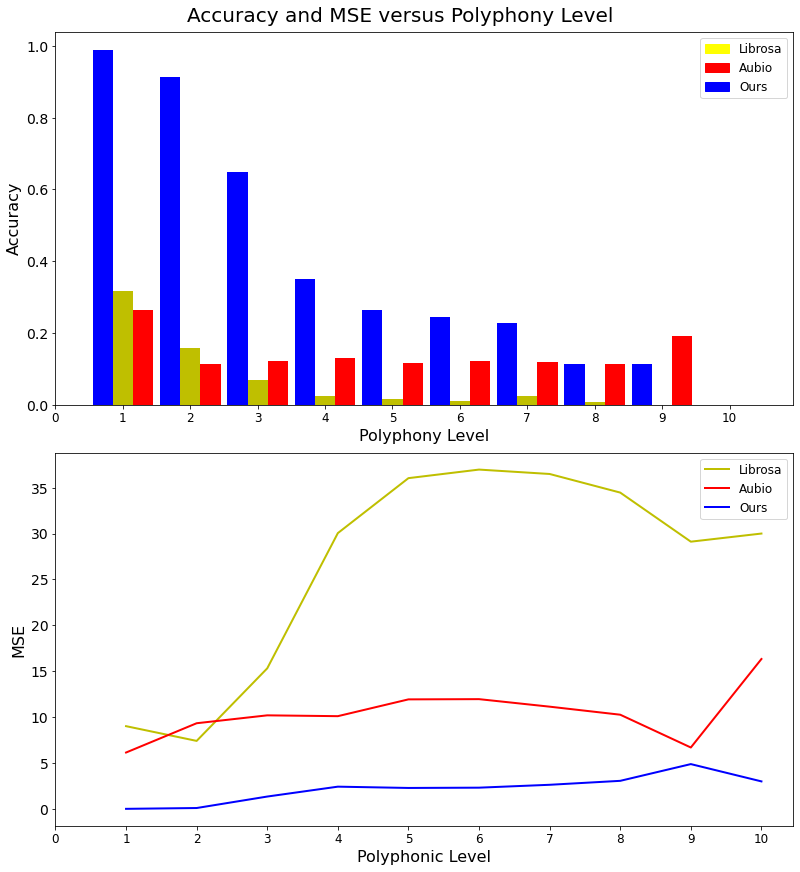

In [164]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.3
x_lst = list(PL_metric)

x1 = [x - width*1.0 for x in x_lst]
ax[0].bar(x1, PL_metric_acc, color='b', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].bar(x_lst, PL_metric_acc_lib, color='y', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x2 = [x + width*1.0 for x in x_lst]
ax[0].bar(x2, PL_metric_acc_aub, color='r', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PL_metric), PL_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PL_metric), PL_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PL_metric), PL_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(len(PL_metric) + 1), xticklabels=range(len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)

# Legends
colors = {'Librosa':'yellow', 'Aubio':'red', 'Ours':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, prop={'size': 12})

ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PL'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### Attribute: SNR level

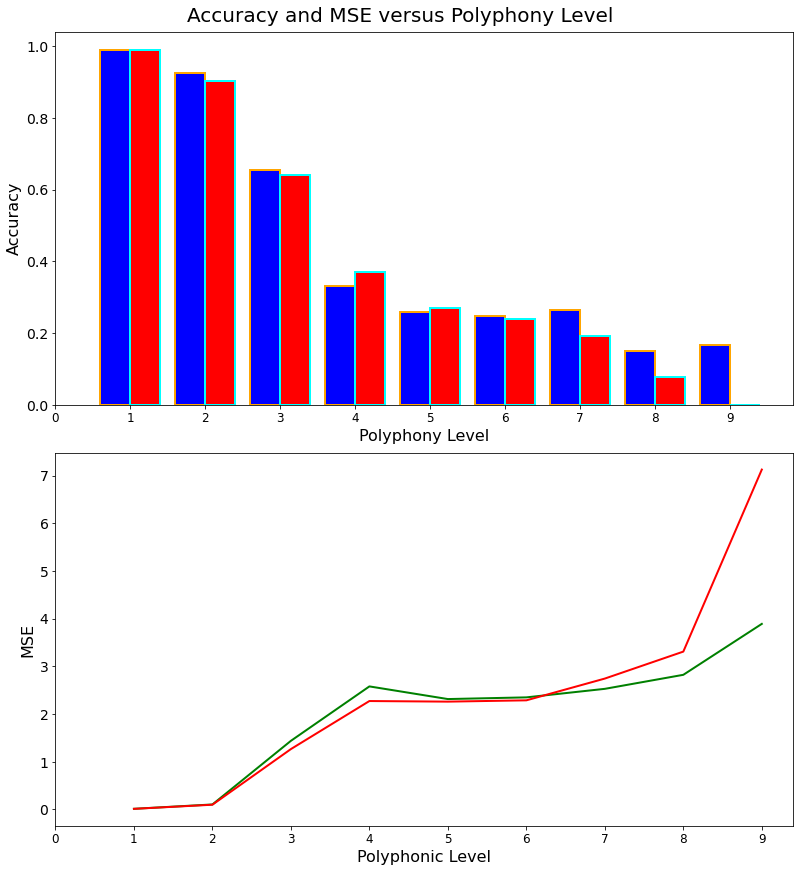

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.4

x_lst = list(PL_metric)
x_lst = [x-width/2 for x in x_lst]
ax[0].bar(x_lst, PL_metric_acc, color='b', 
       edgecolor='orange', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x_lst2 = list(PL_metric)
x_lst2 = [x+width/2 for x in x_lst2]
ax[0].bar(x_lst2, PL_metric_acc_noisy, color='r', 
       edgecolor='cyan', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PL_metric), PL_metric_MSE, color='g', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].plot(list(PL_metric), PL_metric_MSE_noisy, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(len(PL_metric) + 1), xticklabels=range(len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)

fig.savefig(join('images', '40K_PL_SNR'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Ratio

In [166]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicRatio')

Number of test samples =  9998


In [173]:
PR_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx])
            pred_aub.append(Y_aub[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PR_metric[i/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PR_metric)
PR_metric_acc = [item[2][0] for item in list(PR_metric.values())]
PR_metric_MSE = [item[0][0] for item in list(PR_metric.values())]
PR_metric_MDE = [item[1][0] for item in list(PR_metric.values())]
PR_metric_acc_lib = [item[2][1] for item in list(PR_metric.values())]
PR_metric_MSE_lib = [item[0][1] for item in list(PR_metric.values())]
PR_metric_MDE_lib = [item[1][1] for item in list(PR_metric.values())]
PR_metric_acc_aub = [item[2][2] for item in list(PR_metric.values())]
PR_metric_MSE_aub = [item[0][2] for item in list(PR_metric.values())]
PR_metric_MDE_aub = [item[1][2] for item in list(PR_metric.values())]

MSE = 0.034; MDE = 0.034; Accuracy = 96.60%
MSE = 9.491; MDE = 2.042; Accuracy = 18.87%
MSE = 10.879; MDE = 2.721; Accuracy = 4.91%
MSE = 0.057; MDE = 0.057; Accuracy = 94.28%
MSE = 8.755; MDE = 2.014; Accuracy = 15.38%
MSE = 9.801; MDE = 2.527; Accuracy = 9.86%
MSE = 0.195; MDE = 0.174; Accuracy = 83.35%
MSE = 7.636; MDE = 2.173; Accuracy = 12.87%
MSE = 9.210; MDE = 2.342; Accuracy = 12.51%
MSE = 0.853; MDE = 0.446; Accuracy = 69.85%
MSE = 12.950; MDE = 2.945; Accuracy = 8.17%
MSE = 9.343; MDE = 2.413; Accuracy = 13.32%
MSE = 1.884; MDE = 0.877; Accuracy = 48.55%
MSE = 22.077; MDE = 4.080; Accuracy = 4.83%
MSE = 9.222; MDE = 2.397; Accuracy = 14.05%
MSE = 2.608; MDE = 1.206; Accuracy = 31.22%
MSE = 32.323; MDE = 5.212; Accuracy = 2.83%
MSE = 10.614; MDE = 2.624; Accuracy = 11.40%
MSE = 2.663; MDE = 1.271; Accuracy = 24.89%
MSE = 36.936; MDE = 5.704; Accuracy = 1.42%
MSE = 11.239; MDE = 2.654; Accuracy = 12.99%
MSE = 2.392; MDE = 1.229; Accuracy = 22.26%
MSE = 37.498; MDE = 5.754; Accu

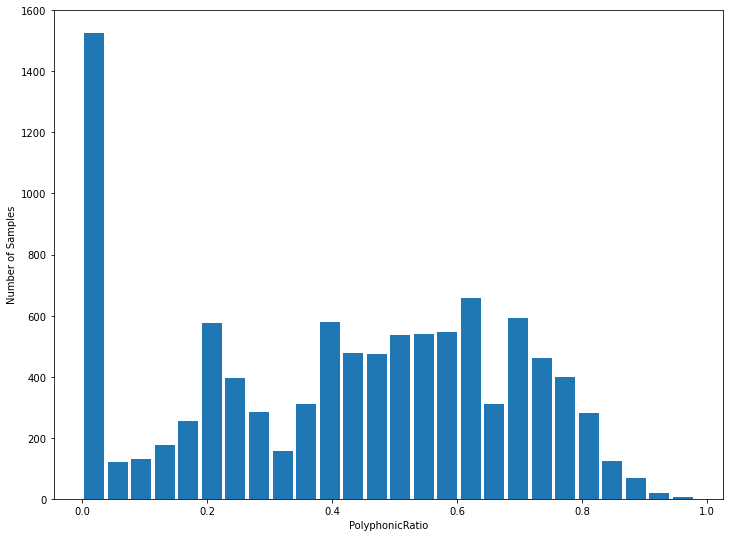

In [171]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicRatio")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

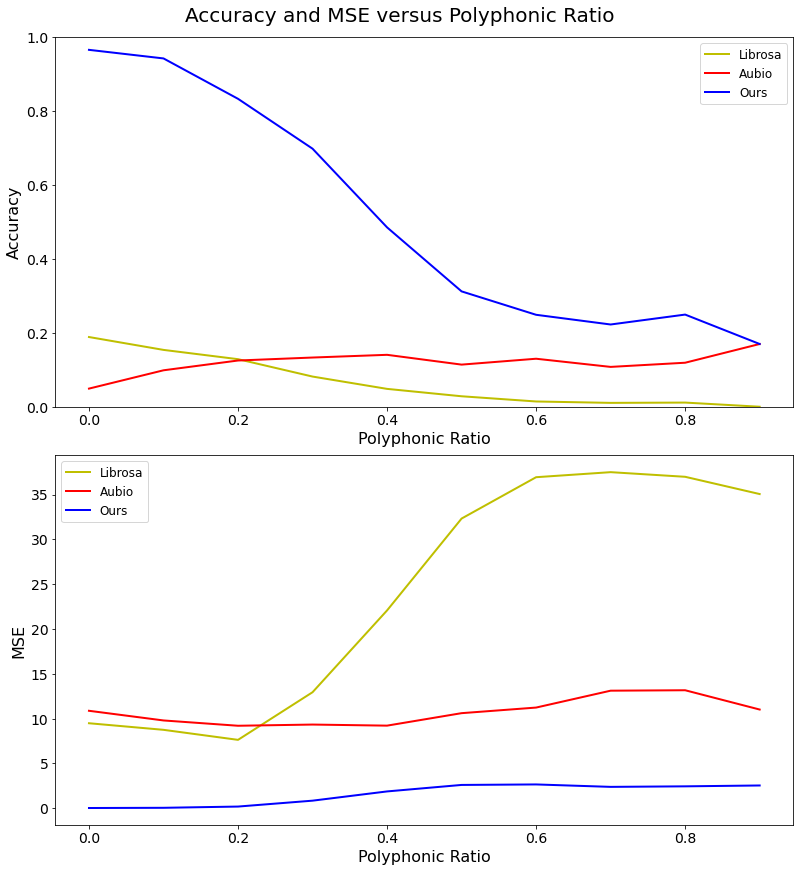

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PR_metric), PR_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PR_metric), PR_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PR_metric), PR_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PR_metric), PR_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PR_metric), PR_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PR_metric), PR_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphonic Ratio", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PR_lib_aub'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Area

In [175]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicArea')

Number of test samples =  9998


In [177]:
PA_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx])
            pred_aub.append(Y_aub[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PA_metric[i/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PA_metric)
PA_metric_acc = [item[2][0] for item in list(PA_metric.values())]
PA_metric_MSE = [item[0][0] for item in list(PA_metric.values())]
PA_metric_MDE = [item[1][0] for item in list(PA_metric.values())]
PA_metric_acc_lib = [item[2][1] for item in list(PA_metric.values())]
PA_metric_MSE_lib = [item[0][1] for item in list(PA_metric.values())]
PA_metric_MDE_lib = [item[1][1] for item in list(PA_metric.values())]
PA_metric_acc_aub = [item[2][2] for item in list(PA_metric.values())]
PA_metric_MSE_aub = [item[0][2] for item in list(PA_metric.values())]
PA_metric_MDE_aub = [item[1][2] for item in list(PA_metric.values())]

MSE = 0.075; MDE = 0.075; Accuracy = 92.52%
MSE = 7.609; MDE = 1.940; Accuracy = 15.68%
MSE = 9.792; MDE = 2.485; Accuracy = 10.19%
MSE = 0.380; MDE = 0.254; Accuracy = 78.76%
MSE = 9.660; MDE = 2.528; Accuracy = 10.17%
MSE = 9.558; MDE = 2.416; Accuracy = 13.58%
MSE = 2.618; MDE = 1.122; Accuracy = 40.47%
MSE = 24.756; MDE = 4.379; Accuracy = 3.82%
MSE = 8.771; MDE = 2.343; Accuracy = 13.07%
MSE = 2.664; MDE = 1.260; Accuracy = 26.16%
MSE = 36.363; MDE = 5.655; Accuracy = 1.84%
MSE = 11.556; MDE = 2.741; Accuracy = 11.83%
MSE = 1.803; MDE = 1.040; Accuracy = 27.99%
MSE = 37.270; MDE = 5.738; Accuracy = 1.58%
MSE = 12.299; MDE = 2.800; Accuracy = 11.16%
MSE = 3.070; MDE = 1.449; Accuracy = 17.02%
MSE = 37.275; MDE = 5.746; Accuracy = 0.90%
MSE = 12.123; MDE = 2.788; Accuracy = 12.97%
MSE = 4.500; MDE = 1.868; Accuracy = 7.89%
MSE = 31.961; MDE = 5.329; Accuracy = 0.00%
MSE = 13.579; MDE = 3.026; Accuracy = 10.53%
{0.0: ([0.07484076433121019, 7.609076433121019, 9.7921974522293], [0.0748

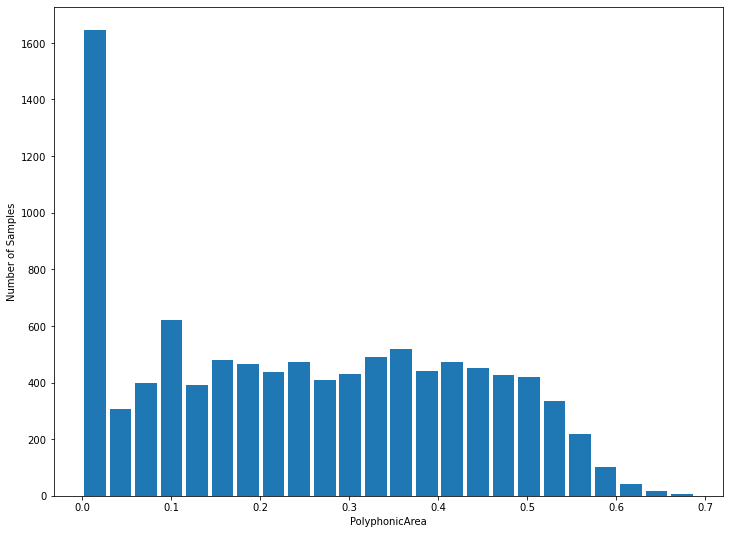

In [178]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicArea")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

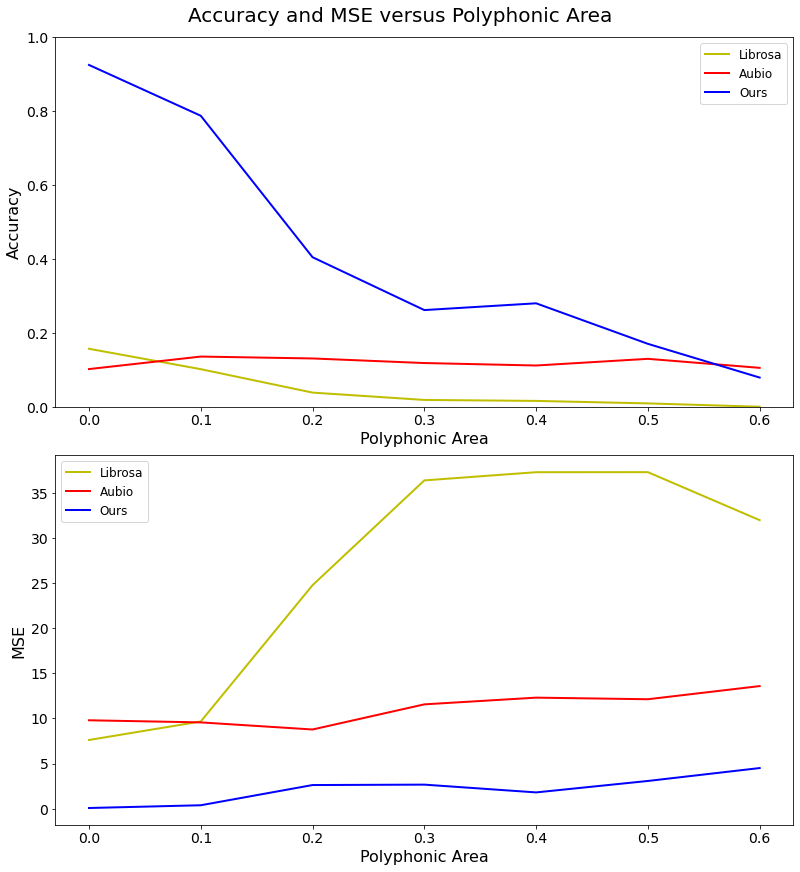

In [179]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PA_metric), PA_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PA_metric), PA_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PA_metric), PA_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Area", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PA_metric), PA_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PA_metric), PA_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PA_metric), PA_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Area", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Area", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphonic Area", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PA_lib_aub'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Density

In [180]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicDensity')

Number of test samples =  9998


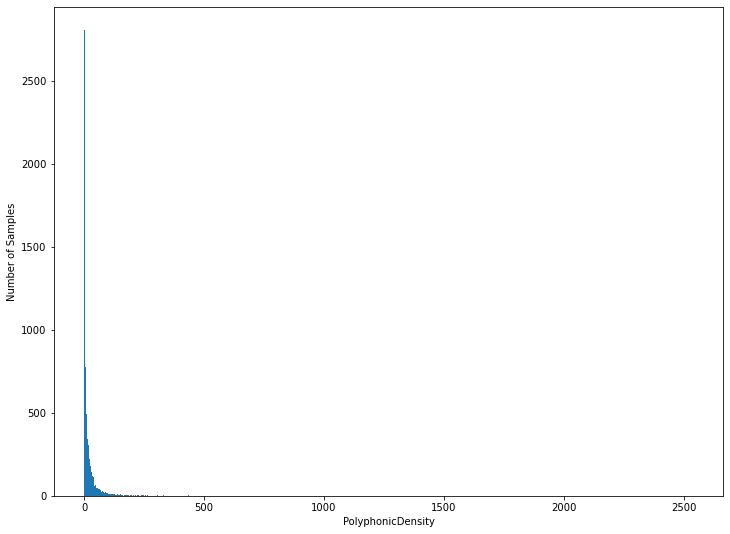

In [181]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicDensity")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

In [182]:
logX = np.log(max(X))
print("Max log(PolyphonicDensity) in the test set is ", logX)

Max log(PolyphonicDensity) in the test set is  7.83896682379672


In [183]:
PD_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > 0:
            if np.log(val) > i*logX/bins and np.log(val) <= (i/bins + 1/bins)*logX:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
                pred_lib.append(Y_lib[idx])
                pred_aub.append(Y_aub[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PD_metric[i*logX/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])

    
print(PD_metric)
PD_metric_acc = [item[2][0] for item in list(PD_metric.values())]
PD_metric_MSE = [item[0][0] for item in list(PD_metric.values())]
PD_metric_MDE = [item[1][0] for item in list(PD_metric.values())]
PD_metric_acc_lib = [item[2][1] for item in list(PD_metric.values())]
PD_metric_MSE_lib = [item[0][1] for item in list(PD_metric.values())]
PD_metric_MDE_lib = [item[1][1] for item in list(PD_metric.values())]
PD_metric_acc_aub = [item[2][2] for item in list(PD_metric.values())]
PD_metric_MSE_aub = [item[0][2] for item in list(PD_metric.values())]
PD_metric_MDE_aub = [item[1][2] for item in list(PD_metric.values())]

MSE = 0.089; MDE = 0.089; Accuracy = 91.09%
MSE = 6.888; MDE = 1.902; Accuracy = 15.59%
MSE = 9.411; MDE = 2.391; Accuracy = 11.84%
MSE = 0.401; MDE = 0.262; Accuracy = 78.46%
MSE = 9.684; MDE = 2.549; Accuracy = 9.17%
MSE = 10.003; MDE = 2.465; Accuracy = 13.68%
MSE = 2.612; MDE = 1.096; Accuracy = 42.16%
MSE = 24.060; MDE = 4.285; Accuracy = 4.54%
MSE = 8.997; MDE = 2.383; Accuracy = 12.99%
MSE = 2.388; MDE = 1.174; Accuracy = 29.03%
MSE = 35.476; MDE = 5.545; Accuracy = 1.94%
MSE = 11.342; MDE = 2.688; Accuracy = 12.12%
MSE = 2.124; MDE = 1.145; Accuracy = 25.30%
MSE = 36.715; MDE = 5.686; Accuracy = 1.33%
MSE = 12.558; MDE = 2.854; Accuracy = 11.82%
MSE = 2.595; MDE = 1.284; Accuracy = 22.24%
MSE = 36.368; MDE = 5.674; Accuracy = 1.18%
MSE = 11.409; MDE = 2.688; Accuracy = 12.11%
MSE = 2.814; MDE = 1.357; Accuracy = 20.16%
MSE = 35.783; MDE = 5.605; Accuracy = 2.71%
MSE = 9.841; MDE = 2.562; Accuracy = 10.08%
MSE = 3.689; MDE = 1.623; Accuracy = 11.48%
MSE = 34.426; MDE = 5.574; Ac

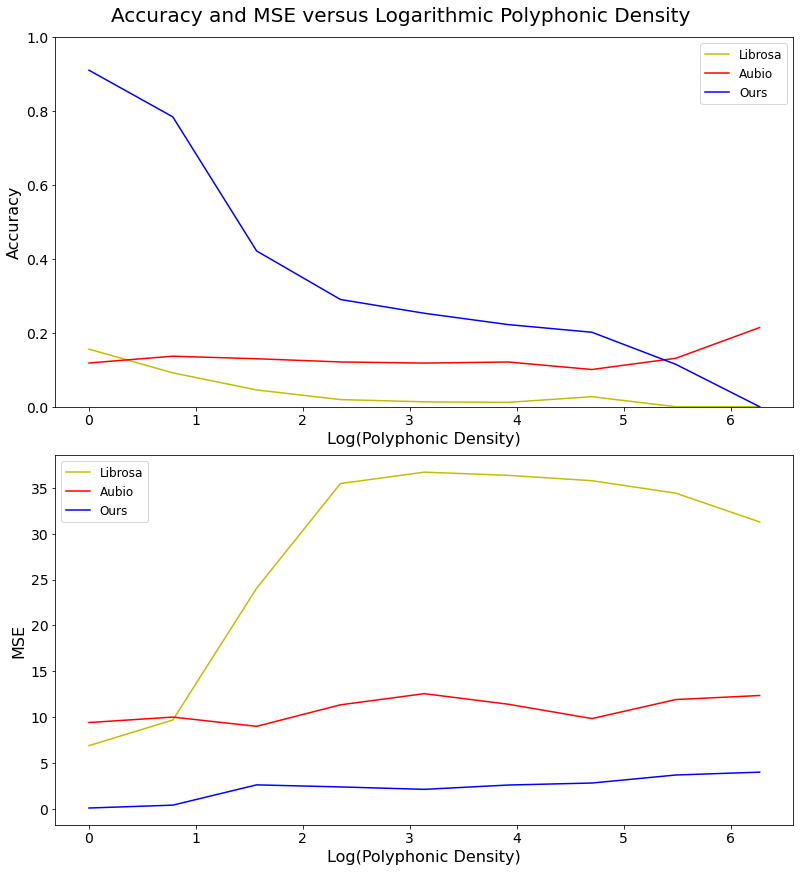

In [185]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PD_metric), PD_metric_acc_lib, color='y', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PD_metric), PD_metric_acc_aub, color='r', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PD_metric), PD_metric_acc, color='b', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PD_metric), PD_metric_MSE_lib, color='y',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PD_metric), PD_metric_MSE_aub, color='r',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PD_metric), PD_metric_MSE, color='b',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Area", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Logarithmic Polyphonic Density", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PD_lib_aub'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()